# TV Show - Jeopardy

Imagine that you want to compete on Jeopardy, and you're looking for any way to win. In this project, you'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random

In [183]:
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [184]:
index = jeopardy.columns
index

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [185]:
columns = {}

for col in index:
    columns[col] = col.strip()


In [186]:
jeopardy = jeopardy.rename(columns=columns)
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

## Normalization 

To analyze the content of all questions and answers, we should clean the values first. 

The main steps include:


- Normalize the 'Question' and 'Answer' column to make the strings as lowercase and remove the punctuation.

- Normalize date and value columns.

In [187]:
def normalization(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^A-Za-z0-9\s]','',sentence)
    sentence = re.sub('\s+',' ', sentence)
    return sentence
    

In [188]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalization)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalization)

In [189]:
jeopardy[['clean_question','clean_answer']].head(5)

,clean_question,clean_answer
0,for the last 8 years of his life galileo was u...,copernicus
1,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,the city of yuma in this state has a record av...,arizona
3,in 1963 live on the art linkletter show this c...,mcdonalds
4,signer of the dec of indep framer of the const...,john adams


Normalize the 'Value' column to remove the dollar sign and turn the 'Air Date' column as datetime for easily further analysis.

In [190]:
def normalize_value(string):
    value = re.sub('[^\w\s]','',string)
    
    try:
        value = int(value)
    except Exception:
        value = 0 
        
    return value

In [191]:
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)

In [192]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In [193]:
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


## Analyze the questions in Jeopardy

In order to know whether it's useful to study previous question to win, we should figure out the questions:

- How often the answer can be used for the questions

- How often the questions are repeated


### 1. Answer in questions

In [194]:
def split_string(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    
    match_count = 0
    
    for i in split_answer:
        if i == 'the':
            split_answer.remove(i)
        elif i in split_question:
            match_count +=1
    if len(split_answer) ==0: return 0        
    res = match_count / len(split_answer)
    return res
        

In [195]:
jeopardy['answer_in_question'] = jeopardy.apply(split_string, axis=1)


In [196]:
avg = round(jeopardy['answer_in_question'].mean(), 2)
avg = avg*100
print('Among all cases, there was a {}% possibility that the answer in the question.'.format(avg))

Among all cases, there was a 6.0% possibility that the answer in the question.


### 2. Repeated questions

In [197]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [198]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [199]:
# sort the dataframe by date
jeopardy = jeopardy.sort_values(by=['Air Date'])

In [200]:
question_overlap = []
terms_used = set()
terms_used_list = list()
for idx, row in jeopardy.iterrows():
    split_question = row['clean_question'].split(' ')
    split_question = [w for w in split_question if len(w) >=6 and w not in stop_words]
    
    match_count = 0
    
    for w in split_question:
        if w in terms_used:
            match_count +=1
        terms_used.add(w)
        terms_used_list.append(w)
    if len(split_question) > 0: 
        rate = match_count / len(split_question)
        
    question_overlap.append(rate)  
    
jeopardy['question_overlap'] = question_overlap
    

In [201]:
question_overlap_mean = round(jeopardy['question_overlap'].mean()*100)

print('There is {} % of meaningful words overlap.'.format(question_overlap_mean))

There is 70.0 % of meaningful words overlap.


## Chi-Squared Test

To figure out whether the overlaped words are significant to questions, especially high-valuable questions, can help us earn more money when participants on Jeopardy.

We can use the chi-squared test to gather the information based on two catergories: high and low value questions.

- **Null Hypothesis** : There is no significant difference of repeated words appearing in high/low valuable questions.


- **Alternative Hypothesis**: There is a significant difference of repeated words appearning in high/low valuable questions.

In [202]:
def sep_value(row):
    if row['clean_value'] > 800:
        value = 1
    else:
        value = 0
        
    return value
jeopardy['high_value'] = jeopardy.apply(sep_value, axis=1)
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap,high_value
19325,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,None,"Adventurous 26th president, he was 1st to ride...",Theodore Roosevelt,adventurous 26th president he was 1st to ride ...,theodore roosevelt,0,0.0,0.0,0
19301,10,1984-09-21,Double Jeopardy!,LABOR UNIONS,$200,Notorious labor leader missing since '75,Jimmy Hoffa,notorious labor leader missing since 75,jimmy hoffa,200,0.0,0.0,0
19302,10,1984-09-21,Double Jeopardy!,1789,$200,"Washington proclaimed Nov. 26, 1789 this first...",Thanksgiving,washington proclaimed nov 26 1789 this first n...,thanksgiving,200,0.0,0.0,0
19303,10,1984-09-21,Double Jeopardy!,TOURIST TRAPS,$200,Both Ferde Grofe' & the Colorado River dug thi...,the Grand Canyon,both ferde grofe the colorado river dug this n...,the grand canyon,200,0.0,0.5,0
19304,10,1984-09-21,Double Jeopardy!,LITERATURE,$200,"Depending on the book, he could be a ""Jones"", ...",Tom,depending on the book he could be a jones a sa...,tom,200,0.0,0.0,0


** Steps of chi-squared test**

- Loop each items of the repeated words set


- assign each word an high and low count representing the occuring frequence in high/low valuable questions. The high/low count are also the real observed results


- calculate the expected the values for each world in high/low avluable questions based on the proportation


- get the test statistic value for each word, and compare results with the 'critical values of the chi-squared distribution with d degrees of freedom'


- gather conclusion

In [203]:

def word_count(word):
    low_count = 0
    high_count = 0
    
    for idx, row in jeopardy.iterrows():
        split_question = row['clean_question'].split(' ')
        
        if word in split_question:
            if row['high_value'] ==1:
                high_count +=1
            else:
                low_count+=1
    return high_count, low_count            
        

In [204]:
observed_expected = []
# select the 100 most frequently appears words as example

most_freq_word = list(pd.Series(terms_used_list).value_counts()[:100].index)
#most_freq_word 

In [205]:
for word in most_freq_word:
    
    observed_expected.append(word_count(word)) 

In [206]:
high_value_count = len(jeopardy[jeopardy['high_value'] == 1])
low_value_count = len(jeopardy[jeopardy['high_value'] == 0])
print(high_value_count)
print(low_value_count)

5734
14265


In [207]:
from scipy.stats import chisquare

chi_squared = []

for k in observed_expected:
    total = k[0]+k[1]
    total_prop = total / len(jeopardy)
    high_expect = total_prop * high_value_count
    low_expect = total_prop * low_value_count
    
    observed = np.array([k[0],k[1]])
    expected = np.array([high_expect, low_expect])
    
    chi_squared.append(chisquare(observed, expected))
        

In [208]:
chi_squared[:5]

[Power_divergenceResult(statistic=4.048305063534577, pvalue=0.044215717944225866),
 Power_divergenceResult(statistic=0.29967829483482744, pvalue=0.5840841713114313),
 Power_divergenceResult(statistic=0.5810990283039111, pvalue=0.4458818590919339),
 Power_divergenceResult(statistic=0.05956570730840162, pvalue=0.8071836789959332),
 Power_divergenceResult(statistic=0.22592591114717697, pvalue=0.6345612982626103)]

** Build a dataframe to clearly show the results of each word**

In [209]:
word_chisq = pd.DataFrame({
          'Word': most_freq_word,
          'High_count': [k[0] for k in observed_expected],
          'Low_count': [k[1] for k in observed_expected],
          'Chi_squared': [k[0] for k in chi_squared],
          'P_value':[k[1] for k in chi_squared]
          })

In [210]:
word_chisq = word_chisq.sort_values(by=['Chi_squared'], ascending=False)
word_chisq = word_chisq[word_chisq['P_value'] < 0.05]
word_chisq = word_chisq.reset_index(drop=True)

In [211]:
word_chisq

,Chi_squared,High_count,Low_count,P_value,Word
0,30.705096,108,133,3.003752e-08,french
1,24.358972,40,33,7.995351e-07,targetblanksarah
2,22.920157,65,73,1.688716e-06,targetblankthisa
3,17.283572,35,33,3.219584e-05,african
4,16.139880,62,79,5.883209e-05,reports
5,15.028297,97,146,1.059112e-04,targetblankherea
6,13.635381,45,54,2.219628e-04,italian
7,12.617237,44,54,3.822059e-04,german
8,12.115584,34,38,5.000218e-04,ancient
9,8.432875,14,79,3.684973e-03,countrys


Since we only select 100 most frequent words from the repeated list, we can analyze the chi_squared results of these words to initially figure out whether they are meaningful to high/low valuable questions.

For each word appearing in the questions, the freedom is one. Assuming the significance level is 0.05, and comparing the test statistic valu (chi_squared) to the chi_square distribution table, we can find that the remained results (we have filtered words which p_value is less than 0.05) can reject the Null hypothesis.

Meanwhile, we can also find that these significant words are more frequently occured in low valuable questions, as their low_count are higher than high_count. Therefore, these words may be more valuable to low value questions

However, for further analysis, we should make some improvements to increase the precision such as enhance the stopwords list.

## General analysis

### 1. Question Topics

In [212]:
# frequent categories
topics = jeopardy['Category'].value_counts(dropna=False)
#topics.value_counts(dropna=False)

In [213]:
# select categoris occurs more than 6 times
popular_topic = topics[topics[topics.index] > 30]

In [214]:
x = list(popular_topic.index)
y = list(popular_topic.values)


([<matplotlib.axis.YTick at 0x7f0253ed1550>,
 <a list of 22 Text yticklabel objects>)

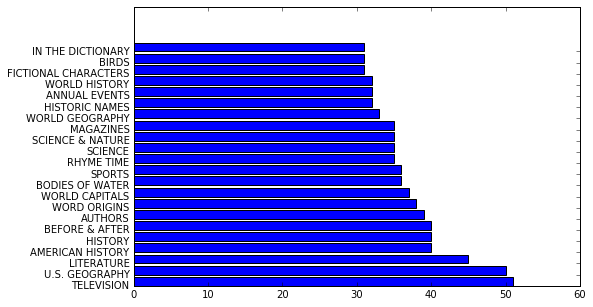

In [215]:
%matplotlib inline
num = range(len(x))
plt.figure(figsize=(8,5))
plt.barh(num ,y )
plt.yticks(num, x)

The most popular categories in Jeopardy are listed above, which can be indicatiors for participants to prepare and fill their knowledge gap.


### 2. Popular categories in different rounds

In [216]:
rounds  = jeopardy['Round'].value_counts(dropna=False)
rounds

Jeopardy!           9901
Double Jeopardy!    9762
Final Jeopardy!      335
Tiebreaker             1
Name: Round, dtype: int64

In [217]:
round_1 = jeopardy[jeopardy['Round'] == 'Jeopardy!']
round_2 = jeopardy[jeopardy['Round'] == 'Double Jeopardy!']
round_3 = jeopardy[jeopardy['Round'] == 'Final Jeopardy!']


In [233]:
titles = ['Categories frequency in round_1',
          'Categories frequency in round_2',
          'Categories frequency in round_3']

axs = []
ays = []

axs.append(list(round_1['Category'].value_counts().index)[:20])
ays.append(list(round_1['Category'].value_counts().values)[:20])

axs.append(list(round_2['Category'].value_counts().index)[:20])
ays.append(list(round_1['Category'].value_counts().values)[:20])

axs.append(list(round_3['Category'].value_counts().index)[:20])
ays.append(list(round_1['Category'].value_counts().values)[:20])


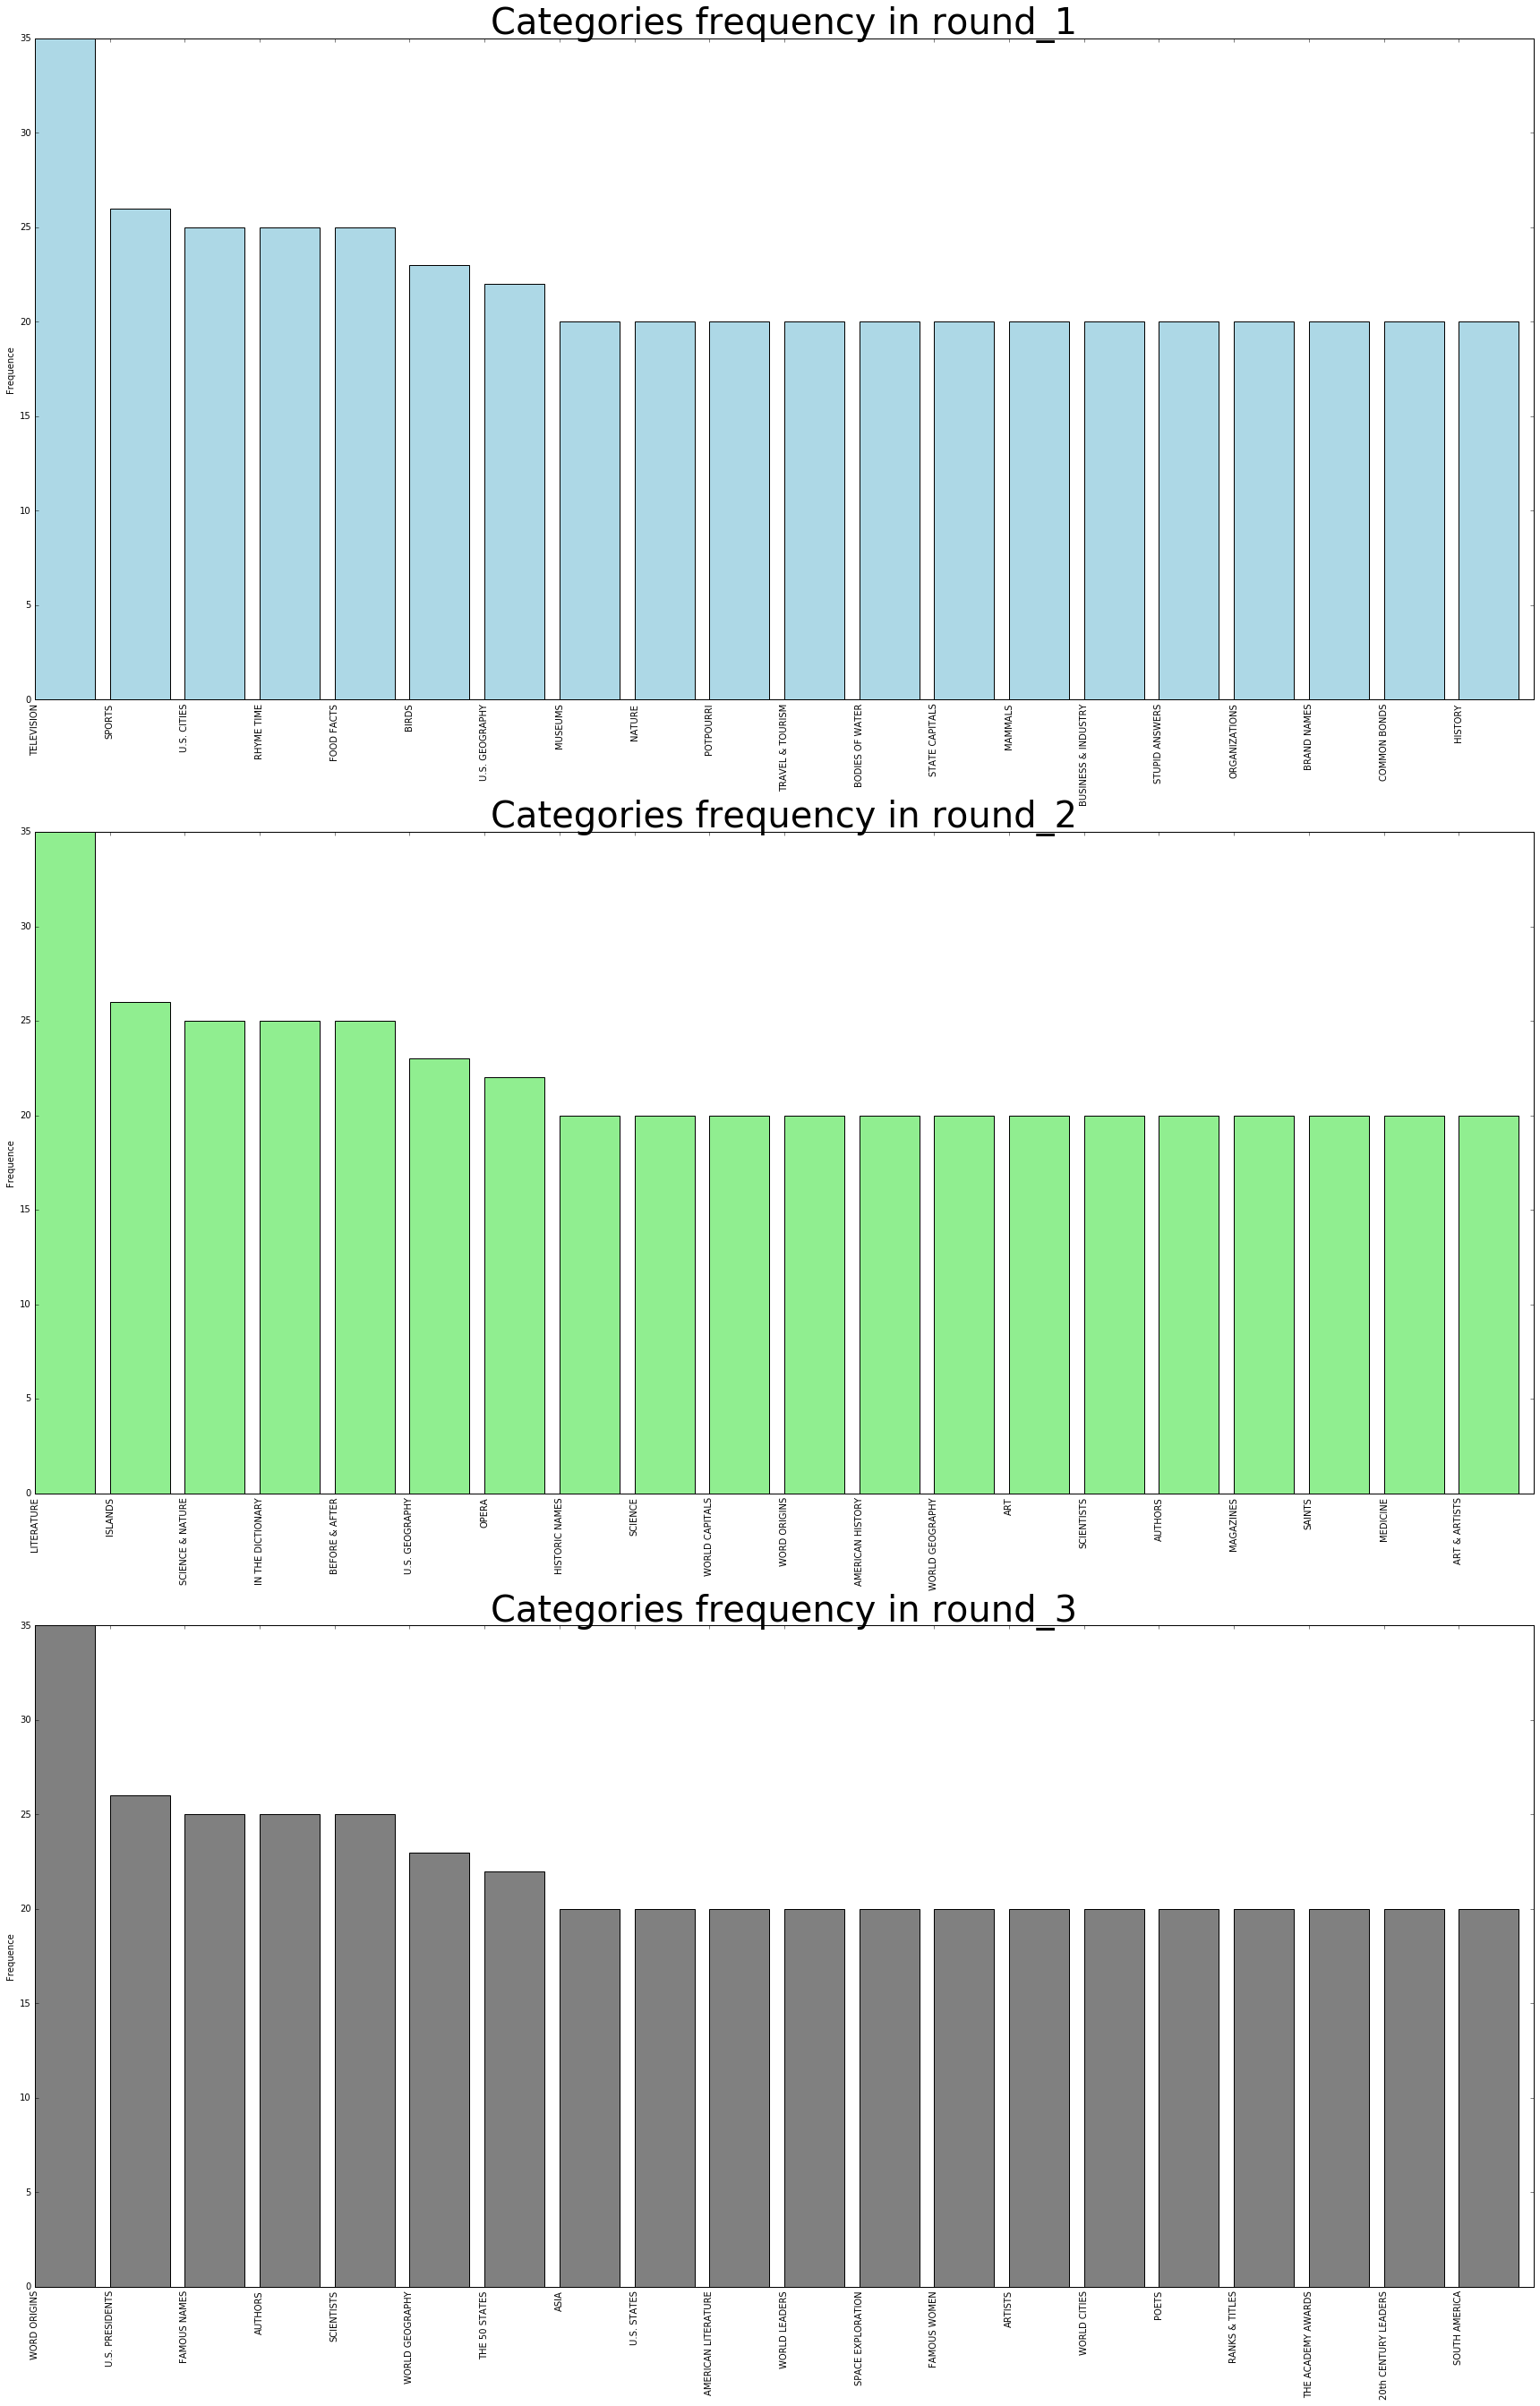

In [269]:
fig = plt.figure(figsize=(30,45))

ax1 = fig.add_subplot(3,1,1)
ax1.bar(range(20), ays[0], color='lightblue')
ax1.set_title(titles[0],fontsize=40)
ax1.set_xticks(range(20))
ax1.set_xticklabels(axs[0],rotation=90)
ax1.set_ylabel('Frequence')

ax2 = fig.add_subplot(3,1,2)
ax2.bar(range(20), ays[1], color='lightgreen')
ax2.set_title(titles[1],fontsize=40)
ax2.set_xticks(range(20))
ax2.set_xticklabels(axs[1],rotation=90)
ax2.set_ylabel('Frequence')

ax3 = fig.add_subplot(3,1,3)
ax3.bar(range(20), ays[2], color='grey')
ax3.set_title(titles[2],fontsize=40)    
ax3.set_xticks(range(20))
ax3.set_xticklabels(axs[2],rotation=90)
ax3.set_ylabel('Frequence')